Loading DataSet

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

data = pd.read_csv("/content/CV_SENTANCES_DATA_BIO_Full_UpdatedResumeDataSet.csv", encoding="latin1").fillna(method="ffill")
data.tail(10)


,Unnamed: 0,sentence_id,word,tag
318405,318405,sentence_31840,window,O
318406,318406,sentence_31840,8,O
318407,318407,sentence_31840,window,O
318408,318408,sentence_31840,10,O
318409,318409,sentence_31840,role,O
318410,318410,sentence_31841,software,B-SKILL
318411,318411,sentence_31841,testing,B-SKILL
318412,318412,sentence_31841,duration,O
318413,318413,sentence_31841,6,O
318414,318414,sentence_31841,month,O


In [2]:
data['tag'].value_counts()

O          291107
B-SKILL     24914
I-SKILL      2369
O-SKILL        25
Name: tag, dtype: int64

In [3]:
class SentenceGetter(object):

    def __init__(self, data):
      self.n_sent = 1
      self.data = data
      self.empty = False
      agg_func = lambda s: [(w, t) for w, t in zip(s["word"].values.tolist(),
                                                   s["tag"].values.tolist())]
      self.grouped = self.data.groupby("sentence_id").apply(agg_func)
      self.sentences = [s for s in self.grouped]

    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

In [4]:
getter = SentenceGetter(data)

In [5]:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['skill',
 'programming',
 'language',
 'python',
 'panda',
 'numpy',
 'scipy',
 'scikit',
 'learn',
 'matplotlib']

In [6]:
labels = [[s[1] for s in sentence] for sentence in getter.sentences]
print(labels[0])

['O', 'B-SKILL', 'I-SKILL', 'B-SKILL', 'O', 'B-SKILL', 'O', 'B-SKILL', 'I-SKILL', 'O']


In [7]:
tag_values = list(set(data["tag"].values))
tag_values.append("PAD")
tag2idx = {t: i for i, t in enumerate(tag_values)}
tag2idx 

{'I-SKILL': 0, 'B-SKILL': 1, 'O': 2, 'O-SKILL': 3, 'PAD': 4}

Apply Bert and
Prepare the sentences and labels

In [8]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 KB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.9 MB/s eta 0:00:00


In [9]:
# we have to prepare the data set for the use with pytorch and BERT
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

#from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

torch.__version__

'1.13.1+cu116'

In [10]:
MAX_LEN = 75  # sequence length of tokens
bs = 32       # batch size

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

In [12]:
torch.cuda.get_device_name(0)

'Tesla T4'

Tokenization

In [13]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased', do_lower_case=False)

In [14]:
def tokenize_and_preserve_labels(sentence, text_labels):
    tokenized_sentence = []
    labels = []

    for word, label in zip(sentence, text_labels):

        # Tokenize the word and count # of subwords the word is broken into
        tokenized_word = tokenizer.tokenize(word)
        n_subwords = len(tokenized_word)

        # Add the tokenized word to the final tokenized word list
        tokenized_sentence.extend(tokenized_word)

        # Add the same label to the new list of labels `n_subwords` times
        labels.extend([label] * n_subwords)

    return tokenized_sentence, labels

In [15]:
tokenized_texts_and_labels = [
    tokenize_and_preserve_labels(sent, labs)
    for sent, labs in zip(sentences, labels)
]

In [16]:
tokenized_texts = [token_label_pair[0] for token_label_pair in tokenized_texts_and_labels]
labels = [token_label_pair[1] for token_label_pair in tokenized_texts_and_labels]

In [17]:
labels[0]


['O',
 'B-SKILL',
 'I-SKILL',
 'B-SKILL',
 'B-SKILL',
 'B-SKILL',
 'O',
 'O',
 'B-SKILL',
 'B-SKILL',
 'B-SKILL',
 'O',
 'O',
 'O',
 'B-SKILL',
 'B-SKILL',
 'B-SKILL',
 'B-SKILL',
 'I-SKILL',
 'O',
 'O',
 'O',
 'O',
 'O']

In [18]:
# we cut and pad the token and label sequences to our desired length
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=MAX_LEN, dtype="long", value=0.0,
                          truncating="post", padding="post")

In [19]:
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in labels],
                     maxlen=MAX_LEN, value=tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")

In [20]:
# we create the mask to ignore the padded elements in the sequences
attention_masks = [[float(i != 0.0) for i in ii] for ii in input_ids]

In [21]:
# we split the dataset to use 10% to validate the model
tr_inputs, val_inputs, tr_tags, val_tags = train_test_split(input_ids, tags,
                                                            random_state=2018, test_size=0.2)
tr_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.2)

In [22]:
import numpy as np
from tensorflow import keras
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(tr_tags, axis=1)
class_weights = compute_class_weight(class_weight ='balanced', classes = np.unique(y_integers), y = y_integers)
d_class_weights = dict(enumerate(class_weights))
print(d_class_weights)
#history = model.fit(input_final, raw_y_train, batch_size=32, class_weight = d_class_weights, epochs=8,callbacks=[checkpoint,reduceLoss],validation_data =(val_final, raw_y_val), verbose=1)

{0: 849.1, 1: 0.2086240786240786, 2: 0.23507751937984497, 3: 0.22088969823100937, 4: 0.29279310344827586, 5: 0.35887573964497044, 6: 0.4770224719101124, 7: 0.5270639354438237, 8: 0.6976992604765817, 9: 0.7670280036133694, 10: 0.9465997770345597, 11: 1.35856, 12: 1.6204198473282443, 13: 2.3985875706214688, 14: 4.691160220994475, 15: 5.586184210526316, 16: 8.937894736842106, 17: 24.973529411764705, 18: 19.297727272727272, 19: 49.94705882352941, 20: 424.55, 21: 141.51666666666668, 22: 424.55, 23: 849.1, 24: 141.51666666666668, 25: 212.275, 26: 169.82, 27: 212.275, 28: 121.3, 29: 169.82}


In [23]:
# we’re operating in pytorch, we have to convert the dataset to torch tensors
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)

In [24]:
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs)

In [25]:
import transformers
from transformers import BertForTokenClassification, AdamW
transformers.__version__

'4.26.1'

In [26]:
#!pip install scikit-learn==0.18 --force-reinstall

In [27]:
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(tag2idx),
    output_attentions = False,
    output_hidden_states = False
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cas

In [28]:
model.cuda();

In [29]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr=3e-5,
    eps=1e-8
)

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
from transformers import get_linear_schedule_with_warmup

epochs = 3
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

In [31]:
!pip install seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=55bf614e5a7196d6326469bb26fd95984453229736b609b72e5b74bc695f7ddf
  Stored in directory: /root/.cache/pip/wheels/e2/a5/92/2c80d1928733611c2747a9820e1324a6835524d9411510c142
Successfully built seqeval


In [32]:
from seqeval.metrics import f1_score, accuracy_score

In [33]:
from tqdm import tqdm, trange

In [34]:

%%time
## Store the average loss after each epoch so we can plot them.
loss_values, validation_loss_values = [], []

for _ in trange(epochs, desc="Epoch"):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.

    # Put the model into training mode.
    model.train()
    # Reset the total loss for this epoch.
    total_loss = 0

    # Training loop
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        # Always clear any previously calculated gradients before performing a backward pass.
        model.zero_grad()
        # forward pass
        # This will return the loss (rather than the model output)
        # because we have provided the `labels`.
        outputs = model(b_input_ids, token_type_ids=None,
                        attention_mask=b_input_mask, labels=b_labels)
        # get the loss
        loss = outputs[0]
        # Perform a backward pass to calculate the gradients.
        loss.backward()
        # track train loss
        total_loss += loss.item()
        # Clip the norm of the gradient
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        # update parameters
        optimizer.step()
        # Update the learning rate.
        scheduler.step()
    
    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)

    print("Average train loss: {}".format(avg_train_loss))

    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    # Put the model into evaluation mode
    model.eval()
    # Reset the validation loss for this epoch.
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
    predictions , true_labels = [], []
    for batch in valid_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        # Telling the model not to compute or store gradients,
        # saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have not provided labels.
            outputs = model(b_input_ids, token_type_ids=None,
                            attention_mask=b_input_mask, labels=b_labels)
        # Move logits and labels to CPU
        logits = outputs[1].detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences.
        eval_loss += outputs[0].mean().item()
        predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
        true_labels.extend(label_ids)

    eval_loss = eval_loss / len(valid_dataloader)
    validation_loss_values.append(eval_loss)
    print("Validation loss: {}".format(eval_loss))
    pred_tags = [tag_values[p_i] for p, l in zip(predictions, true_labels)
                                 for p_i, l_i in zip(p, l) if tag_values[l_i] != "PAD"]
    valid_tags = [tag_values[l_i] for l in true_labels
                                  for l_i in l if tag_values[l_i] != "PAD"]
    print("Validation Accuracy: {}".format(accuracy_score(pred_tags, valid_tags)))
    print("Validation F1-Score: {}".format(f1_score([pred_tags], [valid_tags])))
    print()


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Average train loss: 0.025710176363545167
Validation loss: 0.0030634693487081675
Validation Accuracy: 0.9964188576609248


/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: O-SKILL seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
Epoch:  33%|███▎      | 1/3 [06:18<12:36, 378.01s/it]

Validation F1-Score: 0.9818591267358939

Average train loss: 0.0019868604214211263
Validation loss: 0.001109025985892913
Validation Accuracy: 0.9986967361740707


Epoch:  67%|██████▋   | 2/3 [12:32<06:16, 376.17s/it]

Validation F1-Score: 0.9934575362950963

Average train loss: 0.0007148570027586524
Validation loss: 0.0009270971437081244
Validation Accuracy: 0.9989573889392566


Epoch: 100%|██████████| 3/3 [18:48<00:00, 376.04s/it]

Validation F1-Score: 0.9950806401394856

CPU times: user 17min 51s, sys: 37.7 s, total: 18min 29s
Wall time: 18min 48s


Visualize the training loss

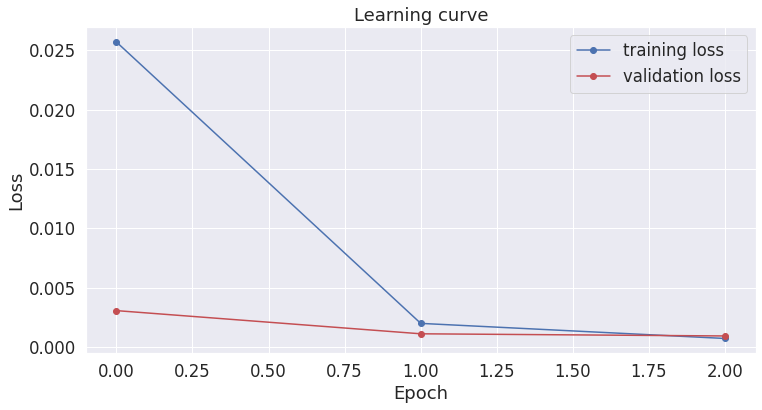

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o', label="training loss")
plt.plot(validation_loss_values, 'r-o', label="validation loss")

# Label the plot.
plt.title("Learning curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()


In [36]:
#test_acc = pd.DataFrame()
#test_acc['valid_tags'] = valid_tags
#test_acc['pred_tags'] = pred_tags
#print(test_acc['valid_tags'].value_counts())
#print(test_acc['pred_tags'].value_counts())

## Model for job title classification

In [37]:
df = pd.read_csv(r"/content/UpdatedResumeDataSet.csv")
df

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...


In [38]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [39]:
import en_core_web_sm
nlp = en_core_web_sm.load()
skill_pattern_path = r"/content/jz_skill_patterns.jsonl"
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [40]:
def get_skills(text):
    doc = nlp(text)
    #print(doc)
    myset = []
    subset = []
    for ent in doc.ents:
        #print("1")
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    #print(subset)
    return subset


def unique_skills(x):
    return list(set(x))

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

!pip install pandas
!pip install pyLDAvis
!pip install spacy download en_core_web_sm

In [42]:
#spacy
import pandas as pd
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

#gensim
import gensim
from gensim import corpora

#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

#Data loading/ Data manipulation
import pandas as pd
import numpy as np


#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

#transformers
from transformers import *
model_name = "bert-base-uncased"
from transformers import DataCollatorForTokenClassification



#warning
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.9/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(


In [43]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
clean = []
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

for review in df["Resume"]:
    # Remove special characters, URLs, and Twitter handles
    review = re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"', " ", review)
    # Convert to lowercase and split into words
    review = review.lower().split()
    # Lemmatize words and remove stop words
    review = [lemmatizer.lemmatize(word) for word in review if word not in stop_words]
    # Join the words back into a single string
    review = " ".join(review)
    clean.append(review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
df["Clean_Resume"] = clean
df["skills"] = df["Clean_Resume"].str.lower().apply(get_skills)
df["skills"] = df["skills"].apply(unique_skills)
df

,Category,Resume,Clean_Resume,skills
0,Data Science,Skills * Programming Languages: Python (pandas...,skill programming language python panda numpy ...,"[data science, hbase, monitoring, dimensionali..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education detail may 2013 may 2017 b e uit rgp...,"[python, time series, machine learning, outlie..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learning control system des...,"[eclipse, linux, data science, segmentation, u..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana tableau sap hana sql s...,"[data science, swift, data processing, segment..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education detail mca ymcaust faridabad haryana...,"[data science, python, data analysis, data str..."
...,...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,computer skill proficient m office word basic ...,"[relay, testing, diagram, electrical engineering]"
958,Testing,â Willingness to accept the challenges. â ...,willingness accept challenge positive thinking...,"[operating system, documentation, testing, sys..."
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",personal skill quick learner eagerness learn n...,"[support, documentation, testing, functional t..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,computer skill software knowledge m power poin...,"[software, design]"


In [45]:
for i in range(df.shape[0]):
    df['skills'].iloc[i] = ' '.join(df['skills'].iloc[i])


In [47]:
print (df['Category'].unique())
print("")
print("Number of datapoints in each categories")
print(df['Category'].value_counts())

['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']

Number of datapoints in each categories
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO               

<AxesSubplot:>

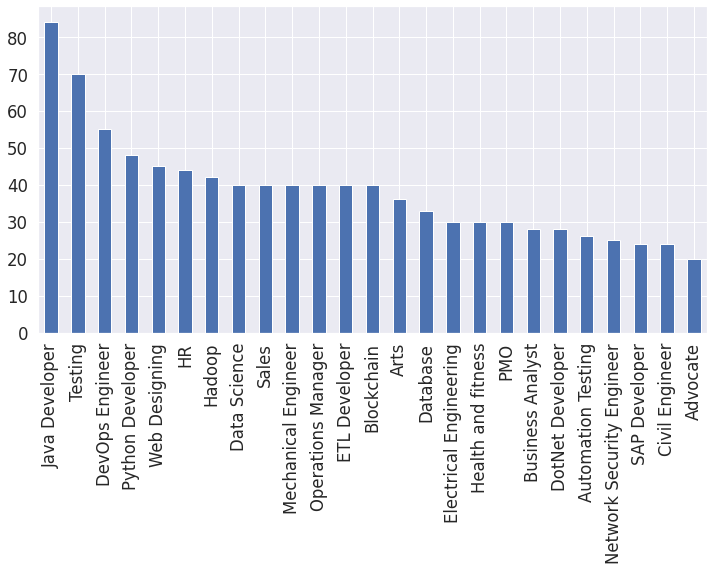

In [48]:
#Visualization of various categories
df['Category'].value_counts(sort=True).nlargest(25).plot.bar()

In [49]:
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
df["Category_N"] = labelencoder.fit_transform(df["Category"])
# print(type(labels))

df

,Category,Resume,Clean_Resume,skills,Category_N
0,Data Science,Skills * Programming Languages: Python (pandas...,skill programming language python panda numpy ...,data science hbase monitoring dimensionality r...,6
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education detail may 2013 may 2017 b e uit rgp...,python time series machine learning outlier bu...,6
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learning control system des...,eclipse linux data science segmentation ubuntu...,6
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana tableau sap hana sql s...,data science swift data processing segmentatio...,6
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education detail mca ymcaust faridabad haryana...,data science python data analysis data structu...,6
...,...,...,...,...,...
957,Testing,Computer Skills: â¢ Proficient in MS office (...,computer skill proficient m office word basic ...,relay testing diagram electrical engineering,23
958,Testing,â Willingness to accept the challenges. â ...,willingness accept challenge positive thinking...,operating system documentation testing system ...,23
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne...",personal skill quick learner eagerness learn n...,support documentation testing functional testi...,23
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...,computer skill software knowledge m power poin...,software design,23


In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer

Text = df['skills'].values
op_labels = df['Category_N'].values
word_vectorizer = TfidfVectorizer(max_features = 1500)
word_vectorizer.fit(Text)
features = word_vectorizer.transform(Text)
type(Text)
Text

array(['data science hbase monitoring dimensionality reduction mysql regular expression predictive coding database visualization analytics time series bootstrap logstash bot computer vision random forest deep learning parse plotly kafka docker tableau machine learning decision tree programming language javascript natural language processing flask numpy git jquery python sentiment analysis accounting file format elasticsearch security cluster analysis cassandra scikit learn',
       'python time series machine learning outlier business dimensionality reduction github ml feature selection',
       'eclipse linux data science segmentation ubuntu mysql jupyter notebook analytics django deep learning design marketing machine learning business github flask software java operating system python segment debian pycharm data analysis electrical engineering engineering aeronautics',
       'data science swift data processing segmentation server database analytics time series deep learning design 

In [51]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(features,op_labels,random_state=0, test_size=0.2)
print(X_train.shape)
print(X_test.shape)
# CountVectorizer(max_features = 2500).fit_transform(df['Clean_Resume']).toarray()

(769, 302)
(193, 302)


KNeighborsClassifier model

In [52]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

In [53]:
clf = OneVsRestClassifier(KNeighborsClassifier())
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of KNeighbors Classifier on test set: {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of KNeighbors Classifier on training set: 0.92
Accuracy of KNeighbors Classifier on test set: 0.89


In [54]:
print("\n Classification report for classifier %s:\n%s\n" % (clf, metrics.classification_report(y_test, prediction)))


 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       1.00      0.67      0.80         3
           2       1.00      0.80      0.89         5
           3       1.00      1.00      1.00         9
           4       0.83      0.83      0.83         6
           5       1.00      1.00      1.00         5
           6       0.71      0.56      0.63         9
           7       1.00      0.43      0.60         7
           8       1.00      0.91      0.95        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         9
          12       0.22      1.00      0.36         5
          13       1.00      1.00      1.00         9
          14       0.00      0.00      0.00         7
          15       1.00      1.00      1.

AdaBoost Classifier

In [55]:
!pip install --upgrade scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                              cmap=plt.cm.Greens):
    plt.figure(figsize=(50, 20), dpi=130)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [57]:
## Decision tree model
from sklearn import tree
import itertools 
import pickle
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
yp = clf.predict(X_test)
print(yp)
acc = accuracy_score(y_test, yp)
print("accuracy is: ",acc)
 

[20 12  6 17 15 12 10 12 15  2  6 23  4 11 13  4 19  8  8  9 12 11 17 22
 19 16  5  8  3  8 20 18  1  7 23 23 22 18  7 20 10 20 12  8 15 15  8 11
  4 22 12 24 12 15 22 23  8 15  3 17 18  3 12 15 15 15 16 21 13 18 12 23
 22 12 13 22  8  7 19  4 24 12  7  1 24 13 12 10  9  8  1  0 23 11  9 23
 11 15 23 13  4 17  2  5  6 10  0 19 20 10  1 10 15 10 15 15 22  6 12  6
  1  4  5  7  9 13 23  6  0  9 21 11  5  3  9 24 19 13  8  3 13 13 11 20
 16 23 21 24  7 21 20 15 22 19 15 23  9 15 15  6  2 20  7 11 23 24  8  3
 20  2 10 22 15  2 11 23  1 23  6  3  3 24 24 12  5 23 18 22 20 20  3  6
 15]
accuracy is:  0.9222797927461139


In [58]:
## RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
RandomForestClassifier()
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
RandomForestClassifier(n_jobs=1)

RandomForestClassifier(n_jobs=1)

In [59]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

# prediction on test set
y_pred=clf.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9222797927461139


In [60]:
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train, y_train)
prediction = clf.predict(X_test)
print('Accuracy of Random forest Classifier on training set: {:.2f}'.format(clf.score(X_train, y_train)))
print('Accuracy of Random forest Classifier on test set:     {:.2f}'.format(clf.score(X_test, y_test)))

Accuracy of Random forest Classifier on training set: 0.96
Accuracy of Random forest Classifier on test set:     0.93


In [61]:
print(clf,metrics.classification_report(y_test,prediction))

RandomForestClassifier()               precision    recall  f1-score   support

           0       1.00      0.33      0.50         3
           1       0.33      0.67      0.44         3
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         6
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         9
           7       1.00      1.00      1.00         7
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00         9
          10       1.00      1.00      1.00         8
          11       1.00      1.00      1.00         9
          12       0.36      1.00      0.53         5
          13       1.00      1.00      1.00         9
          14       0.00      0.00      0.00         7
          15       1.00      1.00      1.00        19
          16       1.00      1.00      1.00         3
  

In [62]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
## xgboost
from xgboost  import XGBClassifier,plot_importance
from sklearn.metrics import accuracy_score

In [64]:
xgb = XGBClassifier()  
xgb.fit(X_train, y_train)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
print(type(X_test))
print(X_test.shape)
y_pred = xgb.predict(X_test)
print(y_pred)
# predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

<class 'scipy.sparse._csr.csr_matrix'>
(193, 302)
[20 12  6 17 15 12 10 12 15  2  6 23  4 11 13  4 19  8  8  9 12 11 17 22
 19 16  5  8  3  8 20 18  1  7 23 23 22 18  7 20 10 20 12  8 15 15  8 11
  4 22 12 24 12 15 22 23  8 15  3 17 18  3 12 15 15 15 16 21 13 18 12 23
 22 12 13 22  8  7 19  4 24 12  7  1 24 13 12 10  9  8  1  9 23 11  9 23
 11 15 23 13  4 17  2  5  6 10  0 19 20 10  1 10 15 10 15 15 22  6 12  6
  1  4  5  7  9 13 23  6  9  9 21 11  5  3  9 24 19 13  8  3 13 13 11 20
 16 23 21 24  7 21 20 15 22 19 15 23  9 15 15  6  2 20  7 11 23 24  8  3
 20  2 10 22 15  2 11 23  1 23  6  3  3 24 24 12  5 23 18 22 20 20  3  6
 15]
Accuracy: 93.26%


Apply the two models on my CV

In [65]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 KB 4.9 MB/s eta 0:00:00


In [68]:

# importing required modules
from PyPDF2 import PdfReader
 
# creating a pdf reader object
reader = PdfReader('/content/AmiraElsayed_CV.pdf')
 
# printing number of pages in pdf file
#print(len(reader.pages))
text = ''

for i in range(len(reader.pages)):
  # getting a specific page from the pdf file
  page = reader.pages[i]
 
  # extracting text from page
  text = text + page.extract_text()

print(len(text))


2689


In [69]:
text

'Exploring new\n \nmachine learning\n \ntechniques and\n \nalgorithms\n\uf004\nParticipating in\n \nmachine learning\n \ncompetitions\n\uf004\nContributing to open-\nsource machine\n \nlearning projects\n\uf004\nInterests\nProgramming Skills\nPython\nC++ & C\nHTML &  CSS\nPHP\nIDEs\nGoogle Colab\nJupyter\nVisual Studio\nEclipse\n MATLAB\nLanguages\nArabic\nEnglish\nSkills\nGiza, Egypt\n\uf015\n+201002892794\n\uf095\namirasyd1998@gmail.com\n\uf0e0\nContact\nAMIRA\nELSAYED\nMACHINE LEARNING ON CLOUD ENGINEER\nAn innovative and experienced Machine Learning on Cloud\n \nEngineer with expertise in designing and deploying large-scale,\n \ndistributed systems for data processing and analysis. Proficient\n \nin AWS cloud computing platforms. Skilled in developing and\n \ndeploying machine learning models using tools such as\n \nTensorFlow, PyTorch, and Scikit-Learn.\nProfile\nEngineering Office for Integrated Projects\n \n(EOIP)\nSoftware Engineer\nFront & back end developer\nFor 5 months\nExp

In [70]:
## we need to clean and generate centances from my cv

# for clean:
import re
#print(text)
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
# Remove special characters, URLs, and Twitter handles
#re.sub(r"(?![\d_])\w","X","dfäg")
review = re.sub('(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"', " ", (text))
# Convert to lowercase and split into words
review = review.lower().split()
# Lemmatize words and remove stop words
review = [lemmatizer.lemmatize(word) for word in review if word not in stop_words]
# Join the words back into a single string
review = " ".join(review)
print("////////////////////")
print(len(review))
print(len(text))


////////////////////
2273
2689


In [71]:
print(review)

exploring new machine learning technique algorithm participating machine learning competition contributing open source machine learning project interest programming skill python c c html cs php ides google colab jupyter visual studio eclipse matlab language arabic english skill giza egypt 201002892794 amirasyd1998 com contact amira elsayed machine learning cloud engineer innovative experienced machine learning cloud engineer expertise designing deploying large scale distributed system data processing analysis proficient aws cloud computing platform skilled developing deploying machine learning model using tool tensorflow pytorch scikit learn profile engineering office integrated project eoip software engineer front back end developer 5 month experience hit solution machine learning engineer name entity recognition project nlp model recognize skill resume build classification model classify job title resume 1 month training electronics communication department faculty engineering cairo 

In [72]:
cv = list(review.split(" "))
len(cv)
cv_sentences = [cv[x:x+10] for x in range(0, len(cv), 10)]
print(len(cv_sentences))
cv_sentences

31


[['exploring',
  'new',
  'machine',
  'learning',
  'technique',
  'algorithm',
  'participating',
  'machine',
  'learning',
  'competition'],
 ['contributing',
  'open',
  'source',
  'machine',
  'learning',
  'project',
  'interest',
  'programming',
  'skill',
  'python'],
 ['c',
  'c',
  'html',
  'cs',
  'php',
  'ides',
  'google',
  'colab',
  'jupyter',
  'visual'],
 ['studio',
  'eclipse',
  'matlab',
  'language',
  'arabic',
  'english',
  'skill',
  'giza',
  'egypt',
  '201002892794'],
 ['amirasyd1998',
  'com',
  'contact',
  'amira',
  'elsayed',
  'machine',
  'learning',
  'cloud',
  'engineer',
  'innovative'],
 ['experienced',
  'machine',
  'learning',
  'cloud',
  'engineer',
  'expertise',
  'designing',
  'deploying',
  'large',
  'scale'],
 ['distributed',
  'system',
  'data',
  'processing',
  'analysis',
  'proficient',
  'aws',
  'cloud',
  'computing',
  'platform'],
 ['skilled',
  'developing',
  'deploying',
  'machine',
  'learning',
  'model',
  'usi

In [73]:
input_ids = []
new_tokens, new_labels = [], []
for i in range(len(cv_sentences)):
  test_sentence = cv_sentences[i]
  tokenized_sentence = tokenizer.encode(test_sentence)
  input_ids.append(torch.tensor([tokenized_sentence]).cuda())
label_indices = []
for i in range(len(input_ids)):
  with torch.no_grad():
    output = model(input_ids[i])
  label_indices = np.argmax(output[0].to('cpu').numpy(), axis=2)
  tokens = tokenizer.convert_ids_to_tokens(input_ids[i].to('cpu').numpy()[0])
  for token, label_idx in zip(tokens, label_indices[0]):
    if token.startswith("##"):
        new_tokens[-1] = new_tokens[-1] + token[2:]
    else:
        new_labels.append(tag_values[label_idx])
        new_tokens.append(token)
  


In [75]:
SKILLS = []
for token, label in zip(new_tokens, new_labels):
  if label in ['B-SKILL', 'I-SKILL', 'O-SKILL']:
    SKILLS.append(token)
    print("{}\t{}".format(label, token))

print(SKILLS)
df_SKILLS = pd.DataFrame()
df_SKILLS['SKILLS'] = SKILLS
df_SKILLS.to_csv('CV_SKILLS.csv')

B-SKILL	machine
I-SKILL	learning
B-SKILL	algorithm
B-SKILL	machine
I-SKILL	learning
B-SKILL	machine
I-SKILL	learning
B-SKILL	eclipse
B-SKILL	machine
I-SKILL	learning
B-SKILL	machine
I-SKILL	learning
B-SKILL	data
I-SKILL	processing
B-SKILL	machine
I-SKILL	learning
B-SKILL	engineering
B-SKILL	software
B-SKILL	front
I-SKILL	end
B-SKILL	[CLS]
B-SKILL	engineering
B-SKILL	machine
I-SKILL	learning
B-SKILL	data
I-SKILL	center
B-SKILL	machine
I-SKILL	learning
B-SKILL	machine
I-SKILL	learning
B-SKILL	natural
I-SKILL	language
I-SKILL	processing
B-SKILL	machine
I-SKILL	learning
B-SKILL	embedded
I-SKILL	system
B-SKILL	database
I-SKILL	analysis
B-SKILL	search
I-SKILL	engine
B-SKILL	eclipse
['machine', 'learning', 'algorithm', 'machine', 'learning', 'machine', 'learning', 'eclipse', 'machine', 'learning', 'machine', 'learning', 'data', 'processing', 'machine', 'learning', 'engineering', 'software', 'front', 'end', '[CLS]', 'engineering', 'machine', 'learning', 'data', 'center', 'machine', 'learning',

In [76]:
skills_list = [' '.join(SKILLS)]
skills = np.array(skills_list)
skills

array(['machine learning algorithm machine learning machine learning eclipse machine learning machine learning data processing machine learning engineering software front end [CLS] engineering machine learning data center machine learning machine learning natural language processing machine learning embedded system database analysis search engine eclipse'],
      dtype='<U348')

In [77]:
from sklearn.feature_extraction.text import TfidfVectorizer

cv_features = word_vectorizer.transform(skills)
cv_features.shape

(1, 302)

In [78]:
# xgboost
y_pred = xgb.predict(cv_features)
print(y_pred)
prediction= labelencoder.inverse_transform(y_pred)
prediction

[6]


array(['Data Science'], dtype=object)

In [79]:
# random forest
y_pred = clf.predict(cv_features)
print(y_pred)
prediction= labelencoder.inverse_transform(y_pred)
prediction

[6]


array(['Data Science'], dtype=object)